In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import json
import pathlib
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np

from lieroy import se3

from recov.datasets import KittiDataset, EthzDataset
from recova.clustering import CenteredClusteringAlgorithm, RegistrationPairClusteringAdapter
from recova.covariance import FixedCenterSamplingDistributionAlgorithm, DistributionAlgorithmToCovarianceAlgorithm
from recova.learning.learning import model_from_file
from recova.registration_result_database import RegistrationPairDatabase

from recova.recov_plot import plot_trajectory_translation, plot_covariance
from recova.trajectory_evaluation import collect_trajectory_data, make_cumulative_covariances, trajectory_linear_length, select_sequential_pairs, make_reference_cum_cov, build_trajectory_from_dataset
from recova.util import set_matplotlibrc

np.set_printoptions(precision=6, linewidth=100)

In [7]:
db_ethz = RegistrationPairDatabase('/home/dlandry/dataset/db_eth_05')

locations = {
    'apartment': (
        db_ethz,
        'apartment',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/apartment')),
        '/home/dlandry/dataset/learning_sets/2018-09-11-inside.json',
        '/home/dlandry/dataset/learning_runs/2018-09-11-apartment.model'
    ),
    'hauptgebaude': (
        db_ethz,
        'hauptgebaude',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/hauptgebaude')),
        '/home/dlandry/dataset/learning_sets/2018-09-11-inside.json',
        '/home/dlandry/dataset/learning_runs/2018-09-11-hauptgebaude.model'
    ),
    'stairs': (
        db_ethz,
        'stairs',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/stairs')),
        '/home/dlandry/dataset/learning_sets/2018-09-11-inside.json',
        '/home/dlandry/dataset/learning_runs/2018-09-11-stairs.model'
    ),
    'gazebo_winter': (
        db_ethz,
        'gazebo_winter',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/gazebo_winter')),
        '/home/dlandry/dataset/learning_sets/2018-09-12-gazebo.json',
        '/home/dlandry/dataset/learning_runs/2018-09-12-gazebo-winter.model'
    ),
    'wood_autumn': (
        db_ethz,
        'wood_autumn',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/wood_autumn')),
        '/home/dlandry/dataset/learning_sets/2018-09-12-wood.json',
        '/home/dlandry/dataset/learning_runs/2018-09-12-wood-autumn.model'
    ),
    'wood_summer': (
        db_ethz,
        'wood_summer',
        EthzDataset(pathlib.Path('/home/dlandry/dataset/ethz/wood_summer')),
        '/home/dlandry/dataset/learning_sets/2018-09-12-wood.json',
        '/home/dlandry/dataset/learning_runs/2018-09-12-wood-summer.model'
    ),
}

In [8]:
def dataset_to_data(db, location, dataset, learning_set_path, model_path, clustering_algo):
    with open(learning_set_path) as f:
        learning_set = json.load(f)
        
    model = model_from_file(model_path, 'cello')
        
    return collect_trajectory_data(db, location, dataset, learning_set['metadata']['descriptor_config'], model, clustering_algo, n_sampled_trajectories=20)

In [9]:
def dataset_to_reference_cov(db, location, dataset, cov_algo):
    pairs = select_sequential_pairs(db, location)
    gt_trajectory = build_trajectory_from_dataset(dataset)
    reference_cum_cov = make_reference_cum_cov(gt_trajectory, pairs, cov_algo)
    
    return (gt_trajectory, reference_cum_cov)



In [30]:
def trajectory_plot(gt_trajectory, cum_covariances, sampled_trajectories, ax):
    FINAL_COLOR='#7dad34'
    COVARIANCE_COLOR='0.8'
    
    gt_handle, = plot_trajectory_translation(gt_trajectory[:], ax, label='GT trajectory', linewidth=1.2)

    endpoints = np.empty((len(sampled_trajectories)-1, 2))
    for i, t in enumerate(sampled_trajectories[:-1]):
        endpoints[i] = t[-1,0:2,3]
        plot_trajectory_translation(t, ax, linestyle='dotted', color='0.1', linewidth=0.8)    
    
    sampled_handle, = plot_trajectory_translation(t[0:500], ax, linestyle='dotted', color='black', label='Sampled\ntrajectories')

    ax.scatter(endpoints[:,0], endpoints[:,1], color=FINAL_COLOR, s=0.8, zorder=100, marker='s')

    for i in range(0, len(gt_trajectory) - 1, 1):
        plot_covariance(gt_trajectory[i], cum_covariances[i], ax, color=COVARIANCE_COLOR, fill=False)
    plot_covariance(gt_trajectory[-1], cum_covariances[-1], ax, color=FINAL_COLOR, fill=False)

    
    cov_legend_handle = matplotlib.patches.Patch(color=COVARIANCE_COLOR, fill=False, label='Estimated\nuncertainty')
    
    ax.grid(color='0.8', linewidth=0.4, zorder=0, linestyle='--')
    
    ax.set_aspect('equal')
    
    
    return gt_handle, sampled_handle, cov_legend_handle

In [31]:
clustering_algo = CenteredClusteringAlgorithm(radius=1.0, k=16, n_seed_init=32)
clustering_algo.seed_selector = 'localized'
clustering_algo.rescale = True

clustering_algo = RegistrationPairClusteringAdapter(clustering_algo)
distr_algo = FixedCenterSamplingDistributionAlgorithm(clustering_algo)
cov_algo = DistributionAlgorithmToCovarianceAlgorithm(distr_algo)

the_location = locations['gazebo_winter']
pairs = select_sequential_pairs(the_location[0], the_location[1])
gt_trajectory = build_trajectory_from_dataset(the_location[2])
reference_cum_cov = make_reference_cum_cov(gt_trajectory, pairs, cov_algo)

(gt_trajectory, 
 sampled_trajectories,
 cum_covariances, 
 censi_cum_cov) = dataset_to_data(*the_location, clustering_algo)

100%|█████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1254.02it/s]


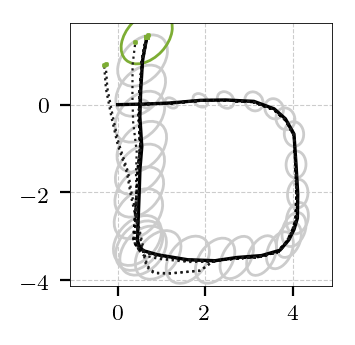

In [32]:
fig, ax = plt.subplots()
fig.set_dpi(200)
fig.set_size_inches((1.75,1.75))

set_matplotlibrc()

handles = trajectory_plot(gt_trajectory, cum_covariances, sampled_trajectories, ax)

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.95)
#plt.legend(handles=[gt_handle, sampled_handle, cov_legend_handle])
plt.savefig('/home/dlandry/traj_trans.pdf')
plt.show()

In [49]:
dat = []
for loc in ['wood_summer', 'hauptgebaude']:
    gt_trajectory, reference_cov = dataset_to_reference_cov(*locations[loc][0:3], cov_algo)
    gt_trajectory, sampled_trajectories, cum_cov, _ =  dataset_to_data(*locations[loc], clustering_algo)
    
    dat.append((gt_trajectory, reference_cov, cum_cov, sampled_trajectories))



100%|█████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1380.60it/s]


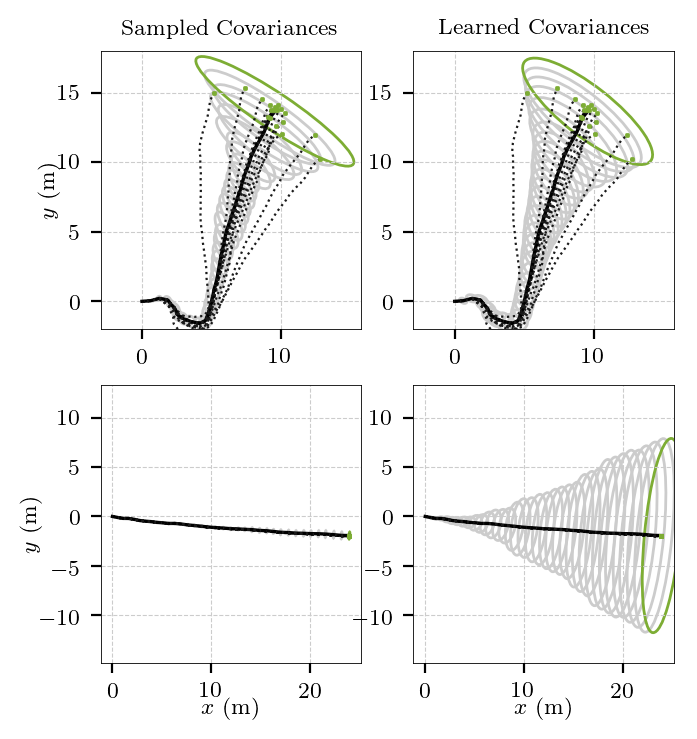

In [50]:
fig, axs = plt.subplots(2,2)
fig.set_dpi(200)
fig.set_size_inches((3.413, 3.6))

set_matplotlibrc()

gt_trajectory, reference_cov, cum_cov, sampled_trajectories = dat[0]
trajectory_plot(gt_trajectory, reference_cov, sampled_trajectories, axs[0][0])
trajectory_plot(gt_trajectory, cum_cov, sampled_trajectories, axs[0][1])

gt_trajectory, reference_cov, cum_cov, sampled_trajectories = dat[1]
trajectory_plot(gt_trajectory, reference_cov, sampled_trajectories, axs[1][0])
trajectory_plot(gt_trajectory, cum_cov, sampled_trajectories, axs[1][1])

axs[0][0].set_title('Sampled Covariances')
axs[0][1].set_title('Learned Covariances')
#axs[1][0].set_title('Gzb. Winter (Sampled)')
#axs[1][1].set_title('Gzb. Winter (Learned)')

axs[1][0].set_xlabel('$x$ (m)', labelpad=-2)
axs[1][1].set_xlabel('$x$ (m)', labelpad=-2)


axs[0][0].set_ylabel('$y$ (m)', labelpad=-1)
axs[1][0].set_ylabel('$y$ (m)', labelpad=-1)

wood_ylims = [-2, 18]
axs[0][0].set_ylim(wood_ylims)
axs[0][1].set_ylim(wood_ylims)

gzb_ylims = [-4.5, 3]
axs[1][0].set_ylim(gzb_ylims)
axs[1][1].set_ylim(gzb_ylims)




plt.subplots_adjust(left=0.11, right=0.95, bottom=0.1, top=0.95)

#plt.show()
plt.savefig('/home/dlandry/all_traj.pdf')